<a href="https://colab.research.google.com/github/cwong79/DATA620/blob/Final/DATA_620_Final_Project_Wong_Author_Gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA 620 FINAL PROJECT

An Exploration of Blog Author Gender Classification
Focusing on Part-of-Speech N-Grams

## Introduction
While online platforms, stylistics and morphological analysis, and thus gender classification, may change over time, the development of Machine Learning models which can be trained on new data, is increasingly important. The standardization through widespread scientific extraction of demographic features from online text can one day be used to anonymize advertising information, as well as to quickly train classifiers on new or unusual online platforms, such as processing niche forums to identify online predators. 

In this project, researchers attempted to reproduce a study by Tai et al. (2020) by running  POS sequence features through a XGB Ensemble method with 10-fold K Fold Cross Validation to tune the XGD hyperparameters. 

I  measured POS pattern frequency, information gain, and accuracy, then compared my results in the context of the work of Mukherjee, A & Liu, B. (2010) who provide an excellent description of common and more traditional feature selection criteria such as F-measure and chi-statistic. In another similar research work, Tai et al. (2020) achieved a 97.4% accuracy on gender identification which they compare to similar approaches by Schler et al. (80.1%) and Goswami et al. (89.3%). 

In this project, I was able to achieve a total accuracy classification score of 60% for gender experiments. Based on POS vectorization research, I have determined POS categories can yield the highest levels of information gains.



### Project Background

Blogging has become a common way of communication on the web. Blogs are written by persons of all ages and gender. Gender classification of blogs can have commercial applications. For example, when integrated with recommender systems, it can help service providers to push relative gender related products/articles/materials to their customers. Conversely, gender classification and deriving other demographic features derived from stylistics can be used to, for example, help identify online predators. 

In recent years, text analysis research has explored the use of various techniques to classify a blog as being written by a male or a female. An example of one such research is conducted by Liu and Mukherjee, titled, Improving Gender Classification of Blog Authors(2010).   In their research, they proposed two novel techniques for gender classification of blogs namely:
 
1. POS sequence patterns (for updated POS methods, see http://nlpprogress.com/english/part-of-speech_tagging.html) that are able to capture complex stylistic regularities of male and female authors and 

2. Ensemble feature selection method which can take advantage of many different types of feature selection criteria. (see: https://scikit-learn.org/stable/modules/ensemble.html)


A more recent survey of online stylistics in Online Social Networks and Writing Styles–A Review of the Multidisciplinary Literature by Tai, K. Y., Dhaliwal, J., & Shariff, S. M. (2020) proposes extracting a more specific tense morphology, “syntactic patterns of “to be” verbs in simple past, simple present, present participle and past participle tenses, with age and gender” with the following methods:

1. Classification Algorithm: Extreme gradient boosting (XGBoost) (see: https://xgboost.readthedocs.io/en/latest/)


2. Dependency Parsing: spaCy (see: https://spacy.io/usage/linguistic-features#dependency-parse) 


3. Cross-categorization: Stratified K-Folds (see: https://scikit-learn.org/stable/modules/cross_validation.html)



### Project Question
This project explores a document classification technique with the objective of answering the following question: 

**What is the potential of XGBoosted POS-based N-Grams in predicting the gender classification, specifically with regard to blog authors?**


In answering this question I reproduce the architecture described in Tai (2020) which uses Spacy-based POS token information, Information Gain, and XGBoost to achieve their stated accuracy. 


(Please note that even though the authors use the word POS for the duration of their article, from reading the results table it is clear they were using Spacy Tags (an extended POS), which I therefore used).



### Data Sources

The primary reference for this project used the dataset cited by Goswami (2009) available https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm and https://www.kaggle.com/rtatman/blog-authorship-corpus?select=blogtext.csv


In order to develop methods that might be useful on this multi-class age and gender dataset; I explored another cited dataset containing only gender:
The data used in this project is taken from the following source:

* Blog Author Gender Classification (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#datasets).


This blogger.com-based dataset  has been successfully employed in several separate studies over the past decade. However, I are concerned that grammatical trends may change over time both among age groups, and by online communities. 


This data set is a spreadsheet with 3226 rows and 2 columns. Column one contains rows of blog posts and column two contains the accurate gender of the author.



### Discussion

Author identification has become an active research area, where the major differences are caused by paper or online medium, mode of entry and target audience. Much research has been devoted to analyzing writing styles in handwritten, word-processed and online social networks (OSN) texts. In their paper titled, " Online Social Networks and Writing Style- A Review of the Multidisciplinary Literature", Tai and others proposed a novel machine learning prediction model based on tense morphology, to classify age and gender from English blogs, and the PAN 2013 dataset. This model achieved an accuracy of 94%-98% and 95%-97% for age and gender, respectively. In their research they also, placed POS words in the syntactic feature category. With reference to work done by other researchers, Tai and others placed function words in the syntactic category.



## Data





### Import Libraries

In [1]:
import random 
import os
import re 
import requests
from google.colab import files

from collections import defaultdict
from operator import itemgetter

import pandas as pd
import numpy as np 

import openpyxl
from pathlib import Path

from PIL import Image
import requests
from io import BytesIO

import spacy
#from spacy.lang.en import English
from xgboost import XGBClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing 

from xgboost import XGBClassifier 

import warnings 
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform

from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from spacy import displacy
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as Disp

### Load Blog Data

In [2]:
blog_file = ("https://github.com/cwong79/DATA620/blob/master/Final/blog-gender-dataset.xlsx?raw=true")

raw_df = pd.read_excel(blog_file, engine='openpyxl', usecols=[0,1], header=None, dtype='str')
raw_df.head()

,0,1
0,Blog,Gender
1,Long time no see. Like always I was rewriting...,M
2,Guest Demo: Eric Iverson’s Itty Bitty Search\...,M
3,Who moved my Cheese??? The world has been de...,M
4,Yesterday I attended a biweekly meeting of an...,M


### Data Formatting

In [3]:
df = raw_df.copy(deep=True)
df.columns = ['text', 'label']

print('Clean Label Text\n')
df['label'] = df.label.str.upper().str.strip()
df['label'] = df.label.astype('category') 

print('Data Type conversion\n') 
#df['text'] = df.text.str.encode('utf-8')
df['text'] = df['text'].astype('string')
df.head()

Clean Label Text

Data Type conversion



,text,label
0,Blog,GENDER
1,Long time no see. Like always I was rewriting...,M
2,Guest Demo: Eric Iverson’s Itty Bitty Search ...,M
3,Who moved my Cheese??? The world has been de...,M
4,Yesterday I attended a biweekly meeting of an...,M


### View Data Statistics

In [4]:
print('\nView class balance:')
print(df.groupby('label').count())
print(df.describe())

print("\nDrop {} NA's:".format(df[df.isnull().any(axis=1)].shape[0]))
print(df[df.isnull().any(axis=1)])

df = df.dropna()
print('\n')
print(df[df.isna().any(axis=1)])
print('\n')
print(df.info())
print('\n')


View class balance:
        text
label       
F       1548
GENDER     1
M       1678
                                                     text label
count                                                3227  3228
unique                                               3216     3
top     Welcome to Grade 1: "Alright students, what do...     M
freq                                                    3  1679

Drop 6 NA's:
      text label
143   <NA>   NaN
1000  <NA>   NaN
1011  <NA>   NaN
1025  <NA>   NaN
1472  <NA>   NaN
1522  <NA>     M


Empty DataFrame
Columns: [text, label]
Index: []


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3227 entries, 0 to 3232
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   text    3227 non-null   string  
 1   label   3227 non-null   category
dtypes: category(1), string(1)
memory usage: 53.7 KB
None




Based on the data statistics for this blog set, there were 1548 blog entries by females and 1678 blog entries by males. In total there were a count of 3226 blog entries. However, 3215 were unique blog entries while 6 had missing data.

### Baseline Accuracy

Our informal baseline is the ratio of classes:

In [5]:
class_prop = round(df.groupby('label').count()/df.shape[0],2)
print('\nClass Proportion:')
print(class_prop)
print('\nBaseline Accuracy: {}%'.format(round(((class_prop.loc['M','text'] * class_prop.loc['M','text']) + (class_prop.loc['F','text'] * class_prop.loc['F','text']))*100,2)))


Class Proportion:
        text
label       
F       0.48
GENDER  0.00
M       0.52

Baseline Accuracy: 50.08%


## Language and Features

Authors have their own style of speaking and writing. The writing style can be used as distinctive features to recognize its author (NagaPrasad et al., 2015). Approximately 1,000 authorship features has been proposed in the literature. The various types of proposed features can be categorized into three main types. They are syntactic, lexical and structural features. Extracting feature vectors based on these feature categories, singularly or combined, can be used in the issue of gender classification. The image below gives a brief description of these features.

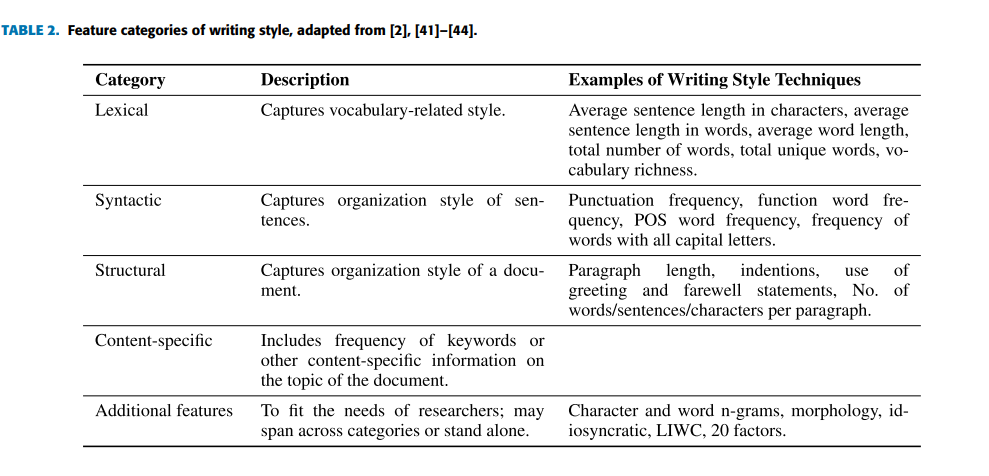

In [6]:
stats="https://github.com/cwong79/DATA620/blob/master/Final/stats.png?raw=true"
Disp.Image(requests.get(stats).content)

### Label Binarization

Label binarization is essential for most machine learning libraries to quantify results. In this case Male and Female are our classes, represented by M and F in the original data, and mapped to 0 and 1 below.

In [7]:
lb = preprocessing.LabelBinarizer()
orig_labels = df.label
df['label'] = lb.fit_transform(df.label)
label_map = list(zip(orig_labels, df.label))
label_dict = dict(list(set(label_map)))
print(label_dict)
df.head()

{'GENDER': 0, 'F': 1, 'M': 0}


,text,label
0,Blog,0
1,Long time no see. Like always I was rewriting...,0
2,Guest Demo: Eric Iverson’s Itty Bitty Search ...,0
3,Who moved my Cheese??? The world has been de...,0
4,Yesterday I attended a biweekly meeting of an...,0


### Using Spacy Models to process POS

spaCy is a library for advanced Natural Language Processing in Python and Cython. It's built on the very latest research, and was designed from day one to be used in real products. spaCy comes with pretrained statistical models and word vectors, and currently supports tokenization for 50+ languages. It features state-of-the-art speed, convolutional neural network models for tagging, parsing and named entity recognition and easy deep learning integration. It's commercial open-source software, released under the MIT license. For example, en_core_web_sm is a small English model trained on written web text (blogs, news, comments), that includes vocabulary, vectors, syntax and entities.


As for the tag attribute, the docs say:

"The English part-of-speech tagger uses the OntoNotes 5 version of the Penn Treebank tag set. I also map the tags to the simpler Universal Dependencies v2 POS tag set."

In [8]:
nlp = spacy.load("en_core_web_sm")

if os.path.exists('pos'): 
  pos = pd.read_pickle('pos')
  df['pos'] = pos.values.tolist()

else:
  #print(nlp.pipe_names)  # ['tagger', 'parser', 'ner', 'print_info']
  docs = list(nlp.pipe(df.text, disable=["parser", "ner", 'print_info']))

  pos = []
  for doc in docs: 
      pos.append([tok.tag_ for tok in doc if tok.tag_ != 'None'])
 
  pos_df = pd.DataFrame(pos)
  pos_df.to_pickle('pos')
  df['pos'] = pos_df.values.tolist()

df.head()

,text,label,pos
0,Blog,0,"[NN, None, None, None, None, None, None, None,..."
1,Long time no see. Like always I was rewriting...,0,"[_SP, JJ, NN, UH, UH, ., UH, RB, PRP, VBD, VBG..."
2,Guest Demo: Eric Iverson’s Itty Bitty Search ...,0,"[_SP, NNP, NNP, :, NNP, NNP, VBZ, NNP, NNP, NN..."
3,Who moved my Cheese??? The world has been de...,0,"[WP, VBD, PRP$, NN, ., ., ., _SP, DT, NN, VBZ,..."
4,Yesterday I attended a biweekly meeting of an...,0,"[_SP, NN, PRP, VBD, DT, JJ, NN, IN, DT, JJ, DT..."


### Vectorize POS

Our list of POS for each document (blog entry) is mapped to a numeric index and saved in the order of occurance for each document (blog entry)

In [9]:
cv_full = CountVectorizer( 
      input='content', 
      lowercase=False,
      preprocessor=lambda x: str(x),
      ngram_range=(1,3) 
)
 
pos_vec  = cv_full.fit_transform(df.pos)
pos_vec_df=pd.DataFrame(pos_vec.toarray(), columns=cv_full.get_feature_names())
pos_vec_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ADD,ADD CC,ADD CC ADD,ADD CC CD,ADD CC DT,ADD CC NN,ADD CC NNP,ADD CC PRP,ADD CC RB,ADD CC VB,ADD CC VBG,ADD CC VBP,ADD CC WRB,ADD CD,ADD CD CD,ADD CD HYPH,ADD CD IN,ADD CD JJ,ADD CD NNP,ADD CD VBP,ADD DT,ADD DT IN,ADD DT JJ,ADD DT NN,ADD DT NNP,ADD DT NNS,ADD DT RB,ADD DT VBN,ADD DT VBZ,ADD EX,ADD EX VBZ,ADD FW,ADD FW FW,ADD FW SYM,ADD HYPH,ADD HYPH NN,ADD HYPH NNP,ADD IN,ADD IN CD,ADD IN DT,...,_SP WRB,_SP WRB CD,_SP WRB DT,_SP WRB IN,_SP WRB JJ,_SP WRB MD,_SP WRB NFP,_SP WRB NN,_SP WRB NNP,_SP WRB NNS,_SP WRB PDT,_SP WRB PRP,_SP WRB RB,_SP WRB TO,_SP WRB VB,_SP WRB VBD,_SP WRB VBG,_SP WRB VBN,_SP WRB VBP,_SP WRB VBZ,_SP WRB _SP,_SP XX,_SP XX CC,_SP XX DT,_SP XX FW,_SP XX NNP,_SP XX None,_SP XX PRP,_SP XX RB,_SP XX UH,_SP XX VBG,_SP XX WP,_SP _SP,_SP _SP DT,_SP _SP JJ,_SP _SP None,_SP _SP PRP,_SP _SP RB,_SP _SP UH,_SP _SP VBD
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Full Data POS Information Gain

"Concisely, the information gain is a measure of the reduction in entropy of the class variable after the value for the feature is observed. In other words, information gain for classification is a measure of how common a feature is in a particular class compared to how common it is in all other classes.

In text classification, feature means the terms appeared in documents (a.k.a corpus). Consider, two terms in the corpus - term1 and term2. If term1 is reducing entropy of the class variable by a larger value than term2, then term1 is more useful than term2 for document classification in this example:

Example in the context of sentiment classification:

A word that occurs primarily in positive movie reviews and rarely in negative reviews contains high information. For example, the presence of the word “magnificent” in a movie review is a strong indicator that the review is positive. That makes “magnificent” a high informative word.""

(Ahmad, 2016)


In [10]:
res = list(zip(cv_full.get_feature_names(),
               mutual_info_classif(pos_vec, df.label, discrete_features=True)
))
if_pos_vec_df = pd.DataFrame(res, columns=['POS', 'Information Gain']).sort_values(by='Information Gain', ascending=False)
if_pos_vec_df.head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,POS,Information Gain
11653,None None None,0.184285
11652,None None,0.184285
11651,None,0.184285
7823,NN,0.069592
12118,PRP,0.062900
3573,IN,0.062686
1839,DT,0.056433
9072,NNP,0.052300
13167,RB,0.049622
4538,JJ,0.043502


Based on POS vectorization, we have determined POS categories which yield the highest levels of information gains. The obvious categories here are “None”, where, if designated the appropriate classification yields up to 18% information gain. Classification appropriation in this instance requires high level of manual work and we will reserve this exercise for future work.



## Text and POS Ngram Visualization

Visualizing our data can help develop intuition and alert us to preprocessing requirements.

In [11]:
df_sample = df.sample(5)
df_sample['doc'] = [nlp(text) for text in df_sample.text]
df_sample.sample(3)
sample_doc = df_sample.iloc[0].doc

#### Word Counts in Blogs

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


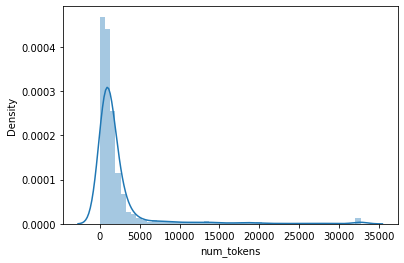

In [12]:
df_plots = pd.DataFrame([])
df_plots['num_tokens'] = [len(token) for token in df.text]
# Visualize histogram of tokens per tweet
g = sns.distplot(df_plots.num_tokens)

#### Additional Directions in Spacy
Here is the range of information available within the Spacy library, in this case Named Entity Recognition. 

In [13]:
doc = nlp(df_sample.iloc[0].text)
html = displacy.render([doc], style='dep', page=True)
spacy.displacy.render(sample_doc, style='ent', jupyter=True)

## Model

I created a model that attempts to reproduces the components of the algorithm and model as described in the narrative under the experiment section in " Online Social Networks and Writing Styles–A Review of the Multidisciplinary Literature" (Tai et al, 2020). First an N-Grams for all Tags is created, as described by Mutual Information and then the use of XGBoost to measure relevance. I charted for Information Gain and Accuracy.

Process: 
- Train-Test-Split
- Performance Grid Search
- Vectorize and create N-Grams (Uni-, Bi-, and Tri-grams) with CountVectorizer
- Classify with XGBoost
- Review Information Gain and Results


### CountVectorize N-Grams of POS

In [14]:
cv = CountVectorizer( 
      input='content', 
      lowercase=False,
      preprocessor=lambda x: str(x),
      ngram_range=(1,3)
)

### Train XGBoost

XGBoost uses a tree based boosting algorithm.

Here are a few key aspects of this package based on the author's paper "XGBoost: A Scalable Tree Boosting System".

"The  learning objective  of the XGBoost function is a set of additive regression trees (refer to section 2.1 of the paper).
Each additive tree contains leaf weights with continuous scores. These are used to classify an example by summing up the scores in the corresponding leaves.
The objective function to be minimized is a regularised differentiable convex loss function that measures the difference between the prediction and the target (as given in equation 2).
As described in this paper (section 2.2), the tree ensemble model in equation 2 includes functions as parameters and cannot be optimized using traditional optimization methods in Euclidean space. Instead, the model is trained in an additive manner."



In [15]:
# Split Train-test

X = df.pos
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = cv.fit_transform(X_train, X_test)
X_test  = cv.transform(X_test)

# train the classifier
clf = XGBClassifier()
model = clf.fit(X_train, y_train)


# test the classifier
y_pred = model.predict(X_test)

In [16]:
# Predict and score the vectors 
acc_score = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred, average='macro')

print('Total accuracy classification score: {:.2f}'.format(acc_score))
print('Total F1 classification score: {:.2f}'.format(f1_score))

Total accuracy classification score: 0.63
Total F1 classification score: 0.63


### Grid Search


XGBoost Parameters

The overall parameters have been divided into 3 categories by XGBoost authors:

* General Parameters: Guide the overall functioning

* Booster Parameters: Guide the individual booster (tree/regression) at each step
* Learning Task Parameters: Guide the optimization performed

In [17]:
warnings.filterwarnings('ignore') 

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

clf = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=21)
 
#start_time = time.time()
clf.fit(X_train, y_train)
#print("\n--- {} seconds ---".format(time.time() - start_time))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f3608eac350>,
                   estimator=XGBClassifier(learning_rate=0.02, n_estimators=600,
                                           nthread=1, silent=True),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=21, scoring='roc_auc', verbose=3)

### Accuracy

I achieved a low accuracy of 60%. However, the authors designated that preprocessing including cleansing, are necessary components to improve the accuracy the model. For the purpose of this experiment, which is the attempt to replicate the authors modeling processes, I believe an improved score can be obtained with other preprocessing tasks.

In [19]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
#print(classification_report(y_test, y_pred, target_names=label_dict.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.631578947368421
Precision: 0.5958904109589042
[[234 118]
 [120 174]]


[[234 118]
 [120 174]]


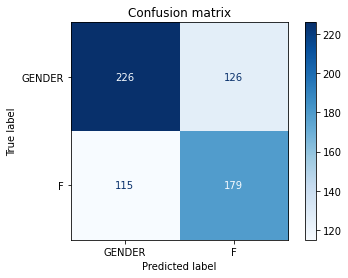

In [20]:
np.set_printoptions(precision=2)
cm = confusion_matrix(y_test, y_pred, labels=None)
print(cm)

plot_confusion_matrix(clf, X_test, y_test,
    display_labels=label_dict.keys(),
    cmap=plt.cm.Blues).ax_.set_title("Confusion matrix")
plt.show()

### Test Data Information Gain

The Unigrams did well, with Trigrams measuring much lower Information Gain (the difference between the relevance of our features for each class is measured with the mutual information function from Sklearn). This is in contrast to the reference which shows Trigrams as occupying a position of highest information gain. 

In [21]:
res = list(zip(cv.get_feature_names(),
               mutual_info_classif(X_train, y_train, discrete_features=True)
))
if_pos_vec_df = pd.DataFrame(res, columns=['POS', 'Information Gain']).sort_values(by='Information Gain', ascending=False)
if_pos_vec_df.head(50)

,POS,Information Gain
11057,None,0.214559
11059,None None None,0.214559
11058,None None,0.214559
7378,NN,0.076613
11490,PRP,0.070970
3380,IN,0.068550
1742,DT,0.060709
8587,NNP,0.060043
12511,RB,0.057880
4300,JJ,0.049462


Testing Dataset

In [22]:
res = list(zip(cv.get_feature_names(),
               mutual_info_classif(X_test, y_test, discrete_features=True)
))
if_pos_vec_df = pd.DataFrame(res, columns=['POS', 'Information Gain']).sort_values(by='Information Gain', ascending=False)
if_pos_vec_df.head(50)

,POS,Information Gain
11059,None None None,0.414205
11057,None,0.414205
11058,None None,0.414205
7378,NN,0.138212
3380,IN,0.116533
1742,DT,0.115850
11490,PRP,0.115043
8587,NNP,0.107695
2047,DT NN,0.093865
12511,RB,0.089604


## Conclusion

In this project, researchers sought to run POS sequence features through a XGB Ensemble method with 10-fold K Fold Cross Validation to tune XGD hyperparameters. My concern here was POS tagging accuracy. 

The main development of my project involved:

1. Using Part of Speech classification to predict the gender of the blog author

2. The proposal of a novel machine learning prediction model based on tense morphology, to classify gender from the blog dataset

3. A review of results from the replication of the "Online Social Networks and Writing Style- A Review of the Multidisciplinary Literature", Tai, Dhaliwal and Mohd Shariff

The researchers were able to show the frequency of syntactic patterns along with their highest information gain based on gender categories. All differences were statistically significant at p < 0.001. However,  since classification appropriation in this instance required high level of manual work I reserved such exercise for future work.

I was able to  achieve a total accuracy classification score of 60% for gender experiments. In contrast, the authors of the key reference paper in this project obtained an accuracy of 95.5% for gender experiments. I suspect the “None” classification factors played a significant role with accuracy scores. It is important to note that these “None” factors yielded the highest levels of information gain. The authors did not describe their method of addressing these types of classifications. I believe that  addressing these factors might yield a higher level of accuracy similar to Tai et al. (2020) whaich was 97.4% accuracy on gender identification which they had compared to similar approaches by Schler et al. (80.1%) and Goswami et al. (89.3%) through the modern approaches available.

On the other hand, bia (2017) writes:
"In tree based ensemble methods, such as XGBoost, each variable is evaluated as a potential splitting variable, which makes them robust to unimportant/irrelevant variables, because such variables that cannot discriminate between events/non-events will not be selected as the splitting variable and hence will be very low on the var importance graph as well. However, a caveat here is that if you have two (or more) highly correlated variables, the importance that you get for these may not be indicative of their actual importance (though even this doesn't affect your model's predictive performance). So you may leave all your features in and run a few iterations to see how important/not they are and the ones that consistently lie at the bottom of the var imp chart can be excluded from subsequent runs to improve computational performance."

This project has caused me to look at morphology and the extended POS system provided by Spacy in new ways. In particular I learned a lot about how N-Grams are used in NLP pipelines, and created a good baseline analysis of the techniques described in Tia et al. (2017). I look forward to exploring how Infromation Gain (or if not pre-processing and exclusion of POS tags) can act in a feature engineering function. The lack of specificity as to the pipeline from POS creating, through to vectorization, and then XGBoost, led us to encounter several technical questions as to the role of feature engineering after vectorization, and particularly the utility of using information gain as a selector against a bagging/boosting routine such as XGBoost. My generic observation is that the accuracy is too low to provide XGBoost a good base to improve, I suspect even with mutual information-based feature selection. This points us to my suspicion that the reference authors may have used a customized Spacy tagger or aggressive text preprocessing. 

I look forward to exploring these questions in the future.


Future Considerations:
- Analyze the occurances of the reference trigrams (and their respective information gain scores)
- Explore more aggressive Text Pre-processing and the signifigance of a None POS
- Explore Feature Selection by mutual information or chi2 to account for possible differences in accuracy from our references
- Explore matrix-based feature selection as a technical output to XGBoost (I noted some bugs with the Sklearn pipeline and XGboost here)
- Per Class Analysis
- Gender and Age Analsis with alternate datasets
- Robust Error Analysis

## References


Ahmad, W. (2016, December 15). How Information Gain Works in Text Classification. Stack Overflow. https://stackoverflow.com/questions/41159030/how-information-gain-works-in-text-classification


Amery, M. (2016, October 27). What do spaCy’s part-of-speech and dependency tags mean? Stack Overflow. https://stackoverflow.com/questions/40288323/what-do-spacys-part-of-speech-and-dependency-tags-mean


Analytics Vidhya. (2016, March). XGBoost Parameter Tuning | Guide To Parameter Tuning in XGBoost. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


Annotation Specifications · spaCy API Documentation. (2017). Retrieved May 25, 2020, from Annotation Specifications website: https://spacy.io/api/annotation


bia. (2017, February 26). Does feature selection help improve the performance of machine learning? Cross Validated. https://stats.stackexchange.com/questions/264093/does-feature-selection-help-improve-the-performance-of-machine-learning


Characeae. (2017, October 15). Information Gain calculation with Scikit-learn. Stack Overflow. https://stackoverflow.com/questions/46752650/information-gain-calculation-with-scikit-learn


Collocations. (2020). Nltk.Org. http://www.nltk.org/howto/collocations.html


Fullwood, M. (2015). Using Pipelines and FeatureUnions in scikit-learn - Michelle Fullwood. Github.Io. https://michelleful.github.io/code-blog/2015/06/20/pipelines/


Girish, R. (2017, November 21). error while predicting test data in xgboost python. Stack Overflow. https://stackoverflow.com/questions/47407996/error-while-predicting-test-data-in-xgboost-python


Goswami, S., Sarkar, S., & Rustagi, M. (n.d.). Stylometric Analysis of Bloggers’ Age and Gender. Retrieved May 26, 2020, from https://pdfs.semanticscholar.org/9904/7f57146703beb82adcc9f910aa1867236422.pdf


Koppel, M. (2020). The Blog Authorship Corpus. Retrieved April 27, 2020, from  Bar-Ilan University website: http://u.cs.biu.ac.il/~koppel/BlogCorpus.htm 


Language Processing Pipelines · spaCy Usage Documentation. (2016). Retrieved May 25, 2020, from Language Processing Pipelines website: https://spacy.io/usage/processing-pipelines


Liu, B. and Hu, M. (2015). Opinion Mining, Sentiment Analysis, Opinion Extraction. Retrieved April 27, 2020, from University of Illinois at Chicago website: https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#datasets


Liu, B. and Mukherjee, A. (2010). Improving gender classification of blog authors. In Proceedings of the 2010 Conference on Empirical Methods in Natural Language Processing (EMNLP ’10). Association for Computational Linguistics, USA, 207–217. Retrieved April 27, 2020, from https://dl.acm.org/doi/10.5555/1870658.1870679 


Nagaprasad, Sriramula & Narsimha, V & Reddy, Vijayapal & Babu, A. (2015). Influence of Lexical, Syntactic and Structural Features and their Combination on Authorship Attribution for Telugu Text. Procedia Computer Science. 48. 58-64. 10.1016/j.procs.2015.04.110. 


Tai, K. Y., Dhaliwal, J., & Shariff, S. M. (2020). Online Social Networks and Writing Styles–A Review of the Multidisciplinary Literature. IEEE Access, 8, 67024–67046. Retrieved April 27, 2020, from https://doi.org/10.1109/access.2020.2985916   


Tatman, R. (2017). Blog Authorship Corpus. Kaggle.Com. https://www.kaggle.com/rtatman/blog-authorship-corpus?select=blogtext.csv


The Blog Authorship Corpus (2020). Retrieved May 26, 2020, from Biu.ac.il website: https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm


tilii7. (2017, October 13). Hyperparameter Grid Search with XGBoost. Kaggle.Com; Kaggle. https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost


tunguz. (2018, March 20). Logistic regression with words and char n-grams. Kaggle.Com; Kaggle. https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams


XGBoost Optimization Function. (2017, December 8). XGBoost Optimization Function. Cross Validated. https://stats.stackexchange.com/questions/317753/xgboost-optimization-function


Yonanam. (2016, March 8). Pass tokens to CountVectorizer. Stack Overflow. https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer


Yonanam.(2016, March 8). Pass tokens CountVectorizer. Stack Overflow.  https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer


Yury Wallet. (2017, December 8). Apply CountVectorizer to column with list of words in rows in Python. Stack Overflow. https://stackoverflow.com/questions/47711515/apply-countvectorizer-to-column-with-list-of-words-in-rows-in-python


‌Lioma, C., & Keith. (2020). Part of speech n-grams and Information Retrieval. Revue Francaise de Linguistique Appliquee, Vol. XIII(1), 9–22. Retrieved from https://www.cairn.info/revue-francaise-de-linguistique-appliquee-2008-1-page-9.htm#


‌Yury Wallet. (2017, December 8). Apply CountVectorizer to column with list of words in rows in Python. Stack Overflow. https://stackoverflow.com/questions/47711515/apply-countvectorizer-to-column-with-list-of-words-in-rows-in-python